## Import Library

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [2]:
from ultralytics import YOLO
import os
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import io
from PIL import Image, UnidentifiedImageError
import random
from tqdm import tqdm
import shutil
from torchvision import transforms
import requests
from io import BytesIO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Data Exploration

### List jumlah label dan gambar

In [3]:
def list_image_folders(
    dataset_path: str = "path_datasetmu/",
    check_images: bool = True,
    min_images: int = 1
) -> List[Tuple[str, int]]:
    """
    Mencetak daftar folder dalam direktori dataset dengan informasi lengkap

    Parameters:
    - dataset_path: Path ke direktori dataset
    - check_images: Cek keberadaan file gambar dalam folder
    - min_images: Minimal jumlah gambar untuk ditampilkan

    Returns:
    - List of tuples (folder_name, image_count)
    """
    path = Path(dataset_path)

    # Validasi path secara detail
    if not path.exists():
        raise FileNotFoundError(f"Error: Direktori '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"Error: '{dataset_path}' bukan direktori")

    # Dapatkan daftar folder dengan Path
    folders = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for entry in path.iterdir():
        if entry.is_dir():
            if check_images:
                # Hitung file gambar dalam folder
                image_count = sum(
                    1 for f in entry.iterdir()
                    if f.is_file() and f.suffix.lower() in valid_extensions
                )
            else:
                image_count = -1  # Flag untuk pengecekan disabled

            if image_count >= min_images:
                folders.append((entry.name, image_count))

    # Urutkan berdasarkan nama folder
    folders.sort(key=lambda x: x[0].lower())

    # Tampilkan output formatting
    if not folders:
        print("Tidak ada folder dengan gambar yang ditemukan")
        return []

    print(f"Ditemukan {len(folders)} folder di '{path.absolute()}':")
    max_name_length = max(len(f[0]) for f in folders)
    count_total = 0
    for i, (folder, count) in enumerate(folders, start=1):
        count_info = f"({count} gambar)" if check_images else ""
        print(f"{i:2d}. {folder:{max_name_length}} {count_info}")
        count_total += count

    print(f"Jumlah Gambar {count_total}")
    return folders

Fungsi diatas berfungsi untuk mencetak daftar folder dalam direktori dataset dengan informasi lengkap.

In [4]:
folders_info = list_image_folders(
    dataset_path="/kaggle/input/realwaste/realwaste-main/RealWaste",
    check_images=True,
    min_images=5
)

# Untuk mendapatkan daftar folder saja
folder_names = [f[0] for f in folders_info]
print("\nDaftar folder tersedia:", folder_names)

Ditemukan 9 folder di '/kaggle/input/realwaste/realwaste-main/RealWaste':
 1. Cardboard           (461 gambar)
 2. Food Organics       (411 gambar)
 3. Glass               (420 gambar)
 4. Metal               (790 gambar)
 5. Miscellaneous Trash (495 gambar)
 6. Paper               (500 gambar)
 7. Plastic             (921 gambar)
 8. Textile Trash       (318 gambar)
 9. Vegetation          (436 gambar)
Jumlah Gambar 4752

Daftar folder tersedia: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


Dari hasil diatas kita dapat melihat informasi setiap folder secara lengkap pada dataset.

### Cek resolusi

In [5]:
def get_resolution_summary(dataset_path: str = "path_datasetmu/"):
    """
    Menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

    Args:
        base_dir (str): Path ke direktori utama dataset.

    Returns:
        None: Mencetak ringkasan resolusi untuk seluruh dataset.
    """
    resolutions = {}
    total_images = 0
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        resolution = (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                        total_images += 1
                except Exception as e:
                    print(f"Gagal membuka atau membaca gambar: {filepath} - {e}")

    unique_resolutions = set(resolutions.keys())
    print(f"Resolusi yang ditemukan: {unique_resolutions}")

    if len(unique_resolutions) == 1:
        for res in unique_resolutions:
            print(f"Semua gambar memiliki resolusi yang seragam: {res}")
    else:
        print("Resolusi tidak seragam.")

    print("\nJumlah gambar per resolusi:")
    for resolution, count in sorted(resolutions.items()):
        print(f"Resolusi {resolution}: {count} gambar")

Fungsi diatas berfungsi untuk menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

In [6]:
get_resolution_summary(dataset_path="/kaggle/input/realwaste/realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 4752 gambar


Dari hasil diatas kita tahu bahwa semua gambar memiliki resolusi yang sama yaitu 524.

### Plot Sampel

In [7]:
def plot_category_samples(
    dataset_path: str = "path_datasetmu/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 8),  # Diperbesar sedikit untuk ruang label
    label_fontsize: int = 12,
    title_fontsize: int = 16,
    dpi: int = 120             # Meningkatkan resolusi
) -> plt.Figure:
    """
    Memvisualisasikan sampel gambar dari setiap kategori dalam dataset

    Parameters:
    - dataset_path: Path ke direktori dataset
    - samples_per_category: Jumlah sampel gambar per kategori yang akan ditampilkan
    - figsize: Ukuran figure matplotlib (width, height)
    - label_fontsize: Ukuran font label kategori
    - title_fontsize: Ukuran font judul
    - dpi: Kualitas output gambar

    Returns:
    - matplotlib Figure object
    """
    path = Path(dataset_path)

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Cari kategori dengan gambar
    categories = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for category_dir in path.iterdir():
        if category_dir.is_dir():
            image_files = [
                f for f in category_dir.iterdir() 
                if f.is_file() and f.suffix.lower() in valid_extensions
            ]
            if image_files:
                categories.append(category_dir.name)

    categories.sort()

    if not categories:
        print("Tidak ada kategori dengan gambar yang ditemukan")
        return None

    # Setup plot
    n_rows = len(categories)
    n_cols = samples_per_category
    
    # Buat figure dengan layout lebih ketat
    fig, axs = plt.subplots(
        n_rows, 
        n_cols,
        figsize=(figsize[0], figsize[1] + n_rows*0.5),
        dpi=dpi,
        gridspec_kw={
            'wspace': 0.05, 
            'hspace': 0.15,  # Ruang vertikal dikurangi
            'left': 0.12      # Margin kiri tetap
        },
        squeeze=False  # Selalu kembalikan array 2D
    )
    
    # Hitung margin kiri berdasarkan nama terpanjang
    max_name_length = max(len(cat) for cat in categories)
    left_margin = max(0.15, 0.03 * max_name_length)
    plt.subplots_adjust(left=left_margin, top=0.92)

    # Tambahkan judul utama
    fig.suptitle(
        f'Contoh Gambar per Kategori (sample: {samples_per_category})',
        fontsize=title_fontsize,
        fontweight='bold'
    )

    # Plot gambar untuk setiap kategori
    for row_idx, category in enumerate(categories):
        category_path = path / category
        image_files = [
            f for f in category_path.iterdir()
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        # Pilih sampel acak
        selected_images = []
        if image_files:
            n_samples = min(samples_per_category, len(image_files))
            selected_indices = np.random.choice(
                len(image_files), 
                n_samples, 
                replace=False
            )
            selected_images = [image_files[i] for i in selected_indices]

        # Plot per sampel
        for col_idx in range(n_cols):
            ax = axs[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f8f8f8')  # Warna background lebih terang
            
            # Tampilkan gambar atau error
            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)
                    
                    # Border estetik
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#e0e0e0')  # Warna lebih lembut
                        spine.set_linewidth(1.5)         # Garis lebih tebal
                except (UnidentifiedImageError, OSError) as e:
                    _add_error_text(ax, f"Error\n{e}")
            else:
                _add_error_text(ax, "Tidak ada\ngambar")

        # Label kategori (kiri tengah)
        axs[row_idx, 0].text(
            -0.25,  # Posisi relatif di luar frame
            0.5,
            category,
            transform=axs[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round,pad=0.3',
                facecolor='#ffffff',   # Latar putih
                edgecolor='#cccccc',    # Border abu-abu
                alpha=0.9,
                linewidth=1.5
            )
        )

    return fig

def _add_error_text(ax, text: str):
    """Helper untuk menambahkan text error di subplot"""
    ax.text(
        0.5, 0.5,
        text,
        ha='center',
        va='center',
        color='#cc0000',  # Merah lebih gelap
        fontsize=9,
        alpha=0.8,
        wrap=True
    )
    ax.set_facecolor('#fff0f0')  # Background merah muda untuk error

Fungsi diatas berfungsi untuk memvisualisasikan sampel gambar dari setiap kategori dalam dataset.

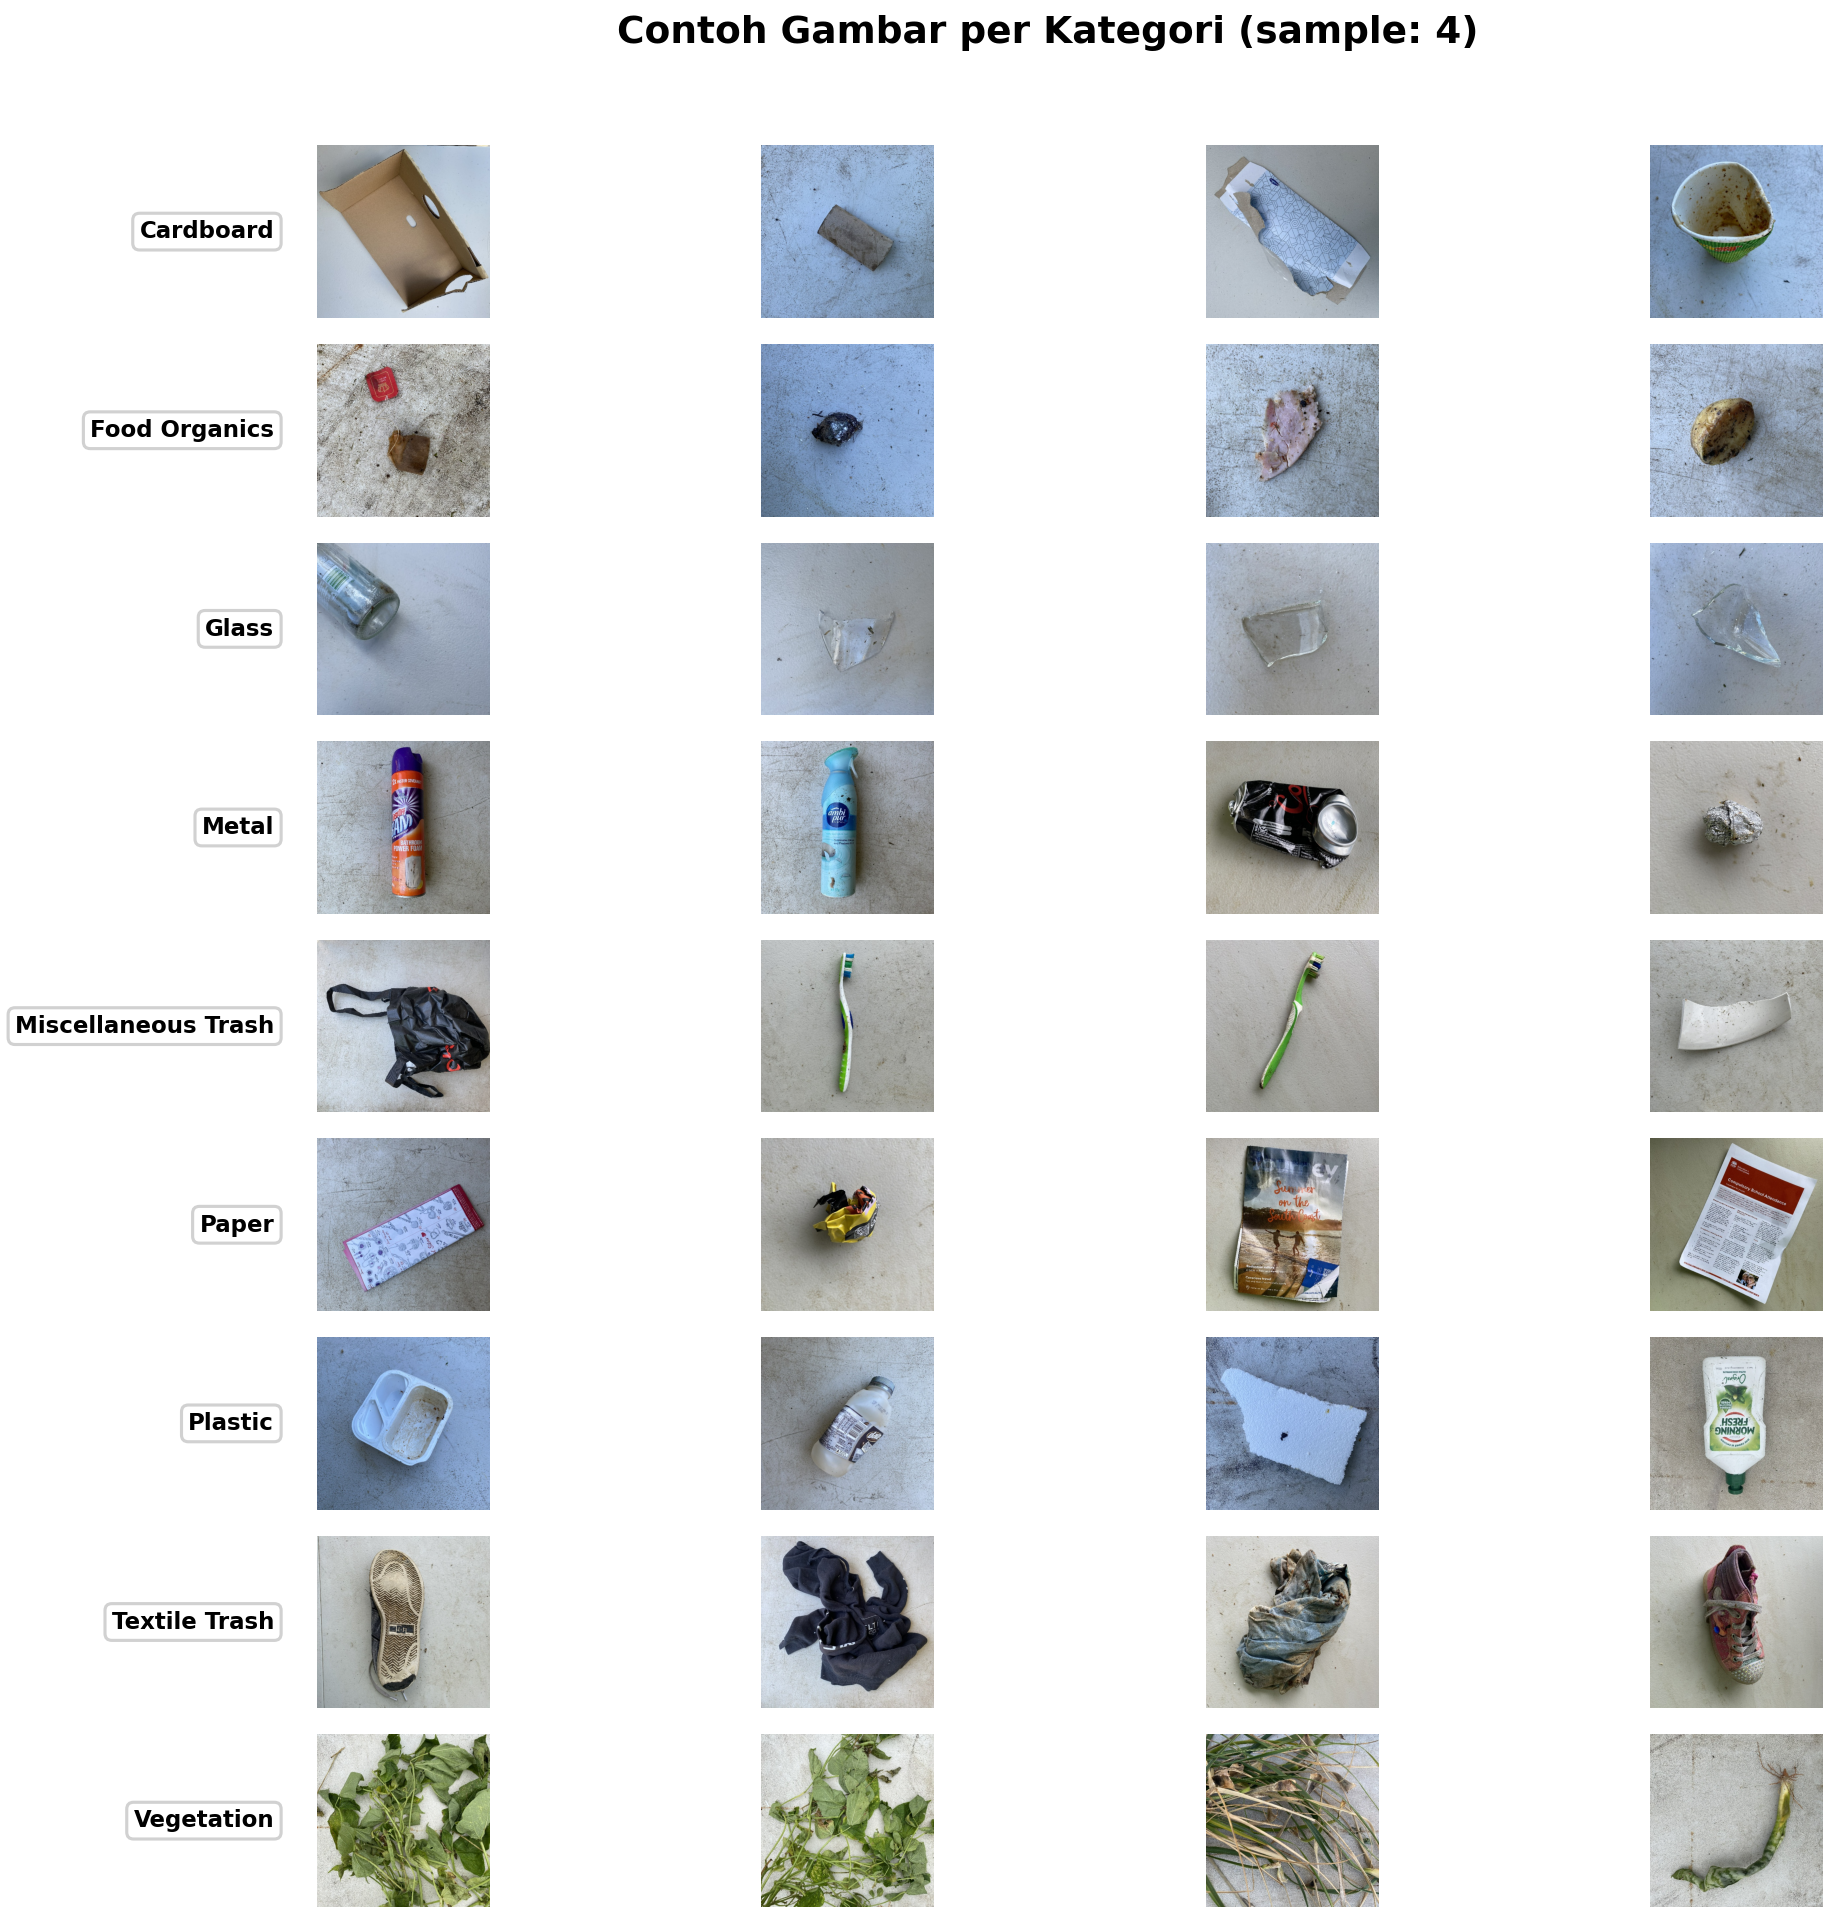

In [8]:
fig = plot_category_samples(
    dataset_path="/kaggle/input/realwaste/realwaste-main/RealWaste",
    samples_per_category=4,
    figsize=(15, 10),
    label_fontsize=11,
    title_fontsize=18,
    dpi=150
)
fig.savefig("preview.png")  # Untuk menyimpan hasil
plt.show()

Dari hasil diatas kita dapat melihat sample gambar pada dataset.

### Distribusi Gambar per Kelas

In [9]:
def analyze_dataset_distribution(dataset_path: str = "path_datasetmy/") -> pd.DataFrame:
    """
    Menganalisis distribusi dataset dengan visualisasi multi-panel terstruktur
    
    Parameters:
    - dataset_path: Path ke direktori dataset
    
    Returns:
    - DataFrame berisi metadata dataset
    """
    path = Path(dataset_path)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Kumpulkan data gambar
    image_data = []
    for img_path in path.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
            relative_path = img_path.relative_to(path)
            label = relative_path.parts[0]
            image_data.append({
                "path": str(img_path),
                "file_name": img_path.name,
                "label": label,
                "extension": img_path.suffix.lower()
            })

    if not image_data:
        raise ValueError("Tidak ditemukan gambar valid dalam dataset")

    df = pd.DataFrame(image_data)
    label_counts = df['label'].value_counts().reset_index()
    label_counts.columns = ['label', 'count']
    total_images = len(df)
    num_categories = len(label_counts)
    
    # Hitung persentase
    label_counts['percentage'] = label_counts['count'] / total_images * 100
    label_counts = label_counts.sort_values('count', ascending=True)

    # Setup figure dengan GridSpec
    fig = plt.figure(figsize=(16, 10), dpi=120, constrained_layout=True)
    fig.suptitle(
        f"Distribusi Dataset Gambar\nTotal: {total_images} Gambar | {num_categories} Kategori",
        fontsize=18,
        fontweight='bold',
        y=0.98
    )
    
    # Buat grid 3x2
    gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])
    
    # Plot 1: Distribusi Kategori (kiri atas ke bawah)
    ax1 = fig.add_subplot(gs[:, 0])  # Menggunakan seluruh kolom pertama
    
    bars = ax1.barh(
        label_counts['label'],
        label_counts['count'],
        color=plt.cm.viridis_r(np.linspace(0.2, 0.8, num_categories)),
        edgecolor='white',
        linewidth=0.7
    )
    
    # Anotasi nilai
    for i, (count, pct) in enumerate(zip(label_counts['count'], label_counts['percentage'])):
        ax1.text(
            count + total_images*0.01,
            i,
            f"{count} ({pct:.1f}%)",
            va='center',
            fontsize=10,
            color='#333333'
        )
    
    ax1.set_title('Distribusi Gambar per Kategori', fontsize=14, pad=15)
    ax1.set_xlabel('Jumlah Gambar', fontsize=12)
    ax1.set_xlim(0, max(label_counts['count']) * 1.25)
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Plot 2: Tabel Ringkasan (kanan atas)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    
    table_data = [
        ["Total Gambar", f"{total_images}"],
        ["Total Kategori", f"{num_categories}"],
        ["Kategori Terbesar", f"{label_counts.iloc[-1]['label']} ({label_counts.iloc[-1]['count']})"],
        ["Kategori Terkecil", f"{label_counts.iloc[0]['label']} ({label_counts.iloc[0]['count']})"],
        ["Ekstensi Utama", f"{df['extension'].value_counts().index[0]} ({df['extension'].value_counts().iloc[0]/total_images:.1%})"]
    ]
    
    table = ax2.table(
        cellText=table_data,
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.4],
        edges='open'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.8)
    ax2.set_title('Ringkasan Dataset', fontsize=14, pad=20)
    
    # Plot 3: Pie Chart Top Kategori (kanan tengah)
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Ambil top 5 kategori
    top_n = min(5, num_categories)
    top_categories = label_counts.tail(top_n).copy()
    others_count = total_images - top_categories['count'].sum()
    
    if others_count > 0:
        top_categories = pd.concat([
            top_categories,
            pd.DataFrame([{'label': 'Lainnya', 'count': others_count, 'percentage': others_count/total_images*100}])
        ])
    
    explode = [0.05] * len(top_categories)
    colors = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(top_categories)))
    
    ax3.pie(
        top_categories['count'],
        labels=top_categories['label'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 9}
    )
    ax3.set_title(f'Top {top_n} Kategori Terbesar', fontsize=14, pad=15)
    ax3.axis('equal')
    
    # Plot 4: Distribusi Ekstensi File (kanan bawah)
    ax4 = fig.add_subplot(gs[2, 1])
    ext_counts = df['extension'].value_counts()
    ext_counts.plot.pie(
        ax=ax4,
        autopct='%1.1f%%',
        colors=plt.cm.Set3.colors,
        startangle=90,
        textprops={'fontsize': 9}
    )
    ax4.set_title('Distribusi Ekstensi File', fontsize=14, pad=15)
    ax4.set_ylabel('')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return df

Fungsi diatas berguna untuk menganalisis distribusi dataset dan membuat visualisasi secara terstruktur.

/tmp/ipykernel_19/2468800054.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


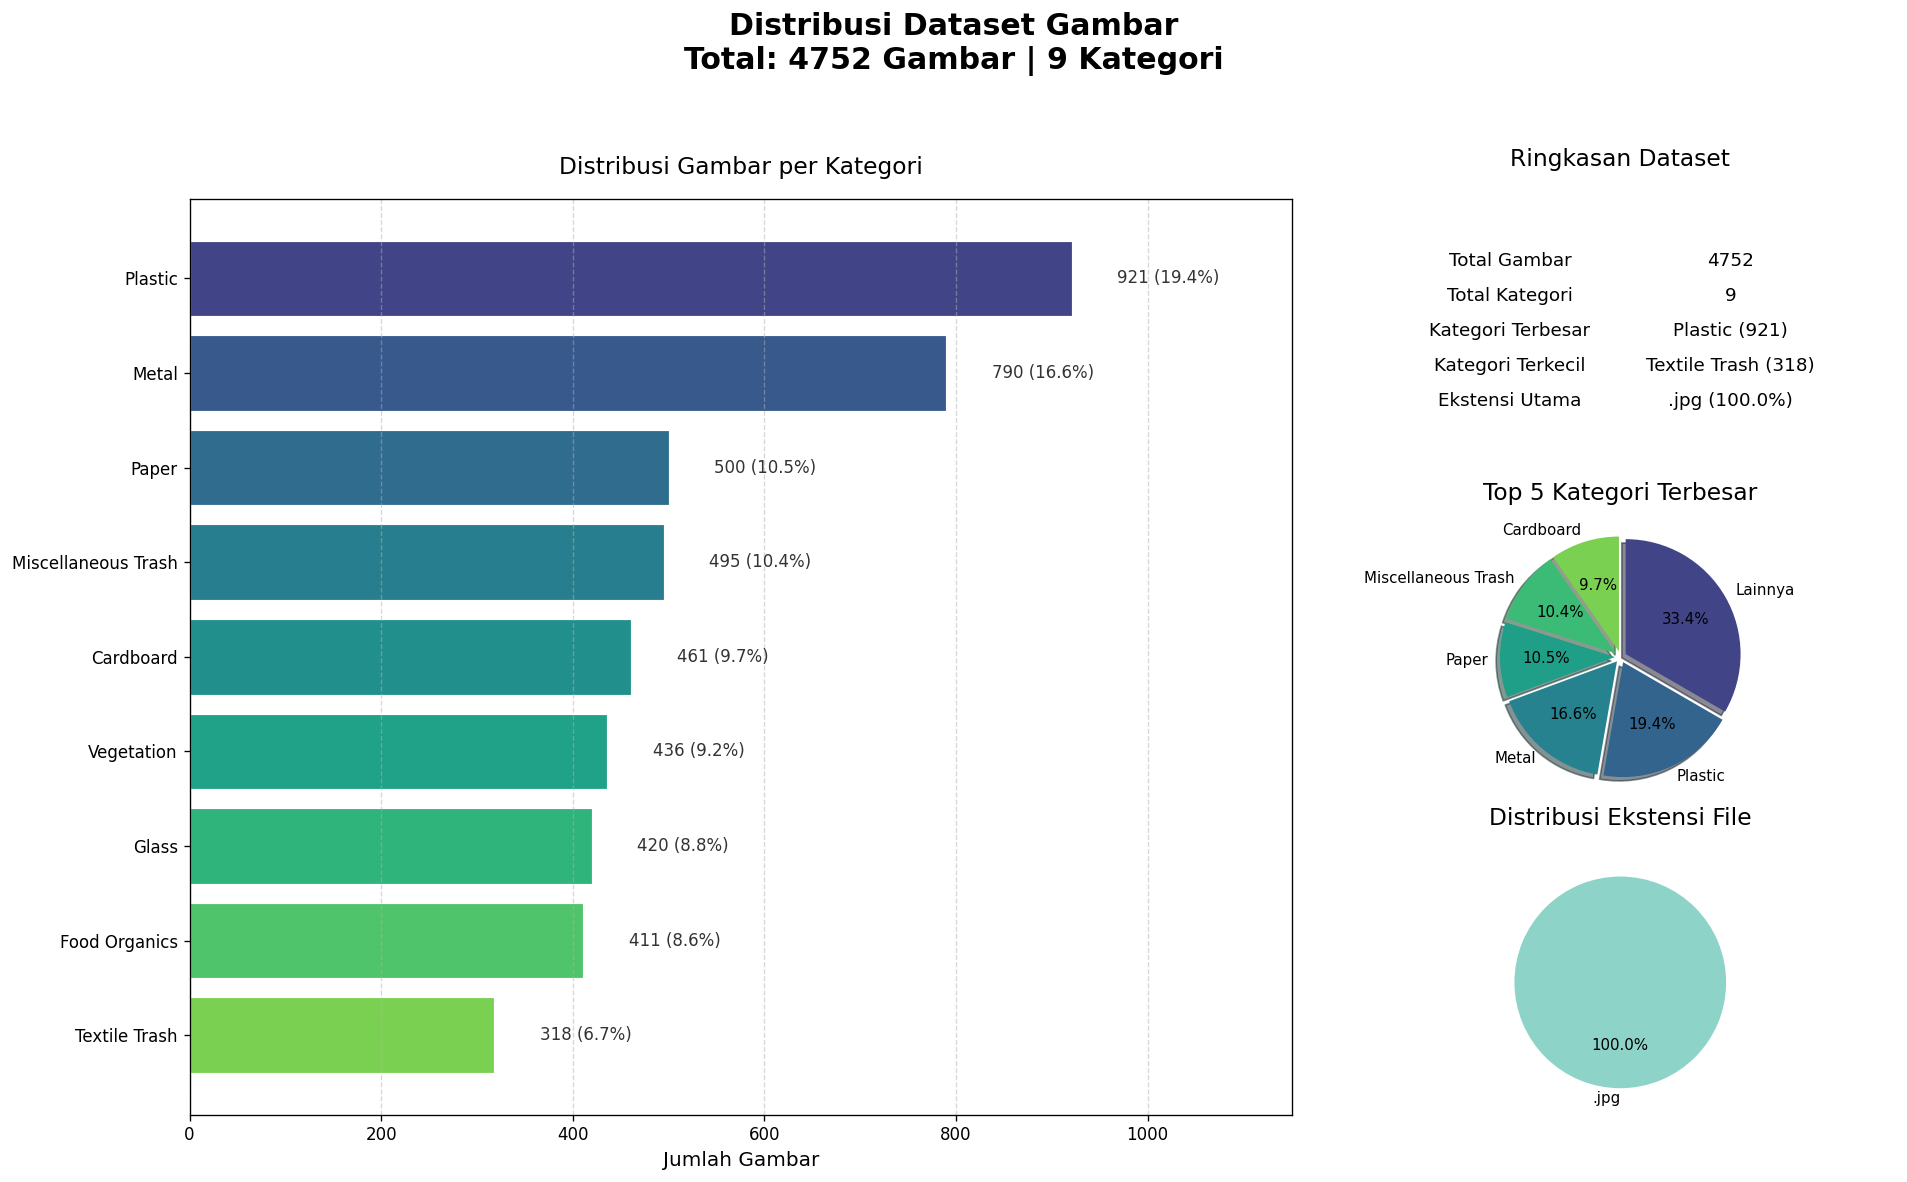

In [10]:
dataset_df = analyze_dataset_distribution(
    dataset_path="/kaggle/input/realwaste/realwaste-main/RealWaste/"
)

## Offline Augmentasi

In [11]:
def augment_underrepresented_classes(
    src_dataset_path: str,
    dst_dataset_path: str,
    target_count: int = 1000
):
    # Salin dataset ke lokasi writable jika belum ada
    if not os.path.exists(dst_dataset_path):
        shutil.copytree(src_dataset_path, dst_dataset_path)
        print(f"✅ Dataset disalin ke {dst_dataset_path}")
    else:
        print(f"📁 Direktori {dst_dataset_path} sudah ada, langsung augmentasi...")

    # Transform augmentasi
    augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2),
        transforms.RandomResizedCrop(size=524, scale=(0.9, 1.0))
    ])

    # Deteksi semua kelas
    class_dirs = [d for d in os.listdir(dst_dataset_path) if os.path.isdir(os.path.join(dst_dataset_path, d))]

    for class_name in class_dirs:
        class_path = os.path.join(dst_dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
        current_count = len(images)

        # Skip jika data sudah mencukupi
        if current_count >= target_count:
            print(f"✅ Class '{class_name}' sudah cukup ({current_count} images), dilewati.")
            continue

        print(f"🔄 Augmenting class '{class_name}' (current: {current_count})")

        i = 0
        while current_count < target_count:
            img_name = images[i % len(images)]
            img_path = os.path.join(class_path, img_name)

            try:
                img = Image.open(img_path).convert('RGB')
                aug_img = augment(img)
                new_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                aug_img.save(os.path.join(class_path, new_img_name))
                current_count += 1
            except Exception as e:
                print(f"❌ Gagal augmentasi {img_path}: {e}")
            i += 1

    print("✅ Semua augmentasi selesai.")

In [12]:
augment_underrepresented_classes(
    src_dataset_path='/kaggle/input/realwaste/realwaste-main/RealWaste',
    dst_dataset_path='/kaggle/working/RealWaste',
    target_count=1000
)

✅ Dataset disalin ke /kaggle/working/RealWaste
🔄 Augmenting class 'Plastic' (current: 921)
🔄 Augmenting class 'Paper' (current: 500)
🔄 Augmenting class 'Food Organics' (current: 411)
🔄 Augmenting class 'Textile Trash' (current: 318)
🔄 Augmenting class 'Vegetation' (current: 436)
🔄 Augmenting class 'Glass' (current: 420)
🔄 Augmenting class 'Cardboard' (current: 461)
🔄 Augmenting class 'Metal' (current: 790)
🔄 Augmenting class 'Miscellaneous Trash' (current: 495)
✅ Semua augmentasi selesai.


/tmp/ipykernel_19/2468800054.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


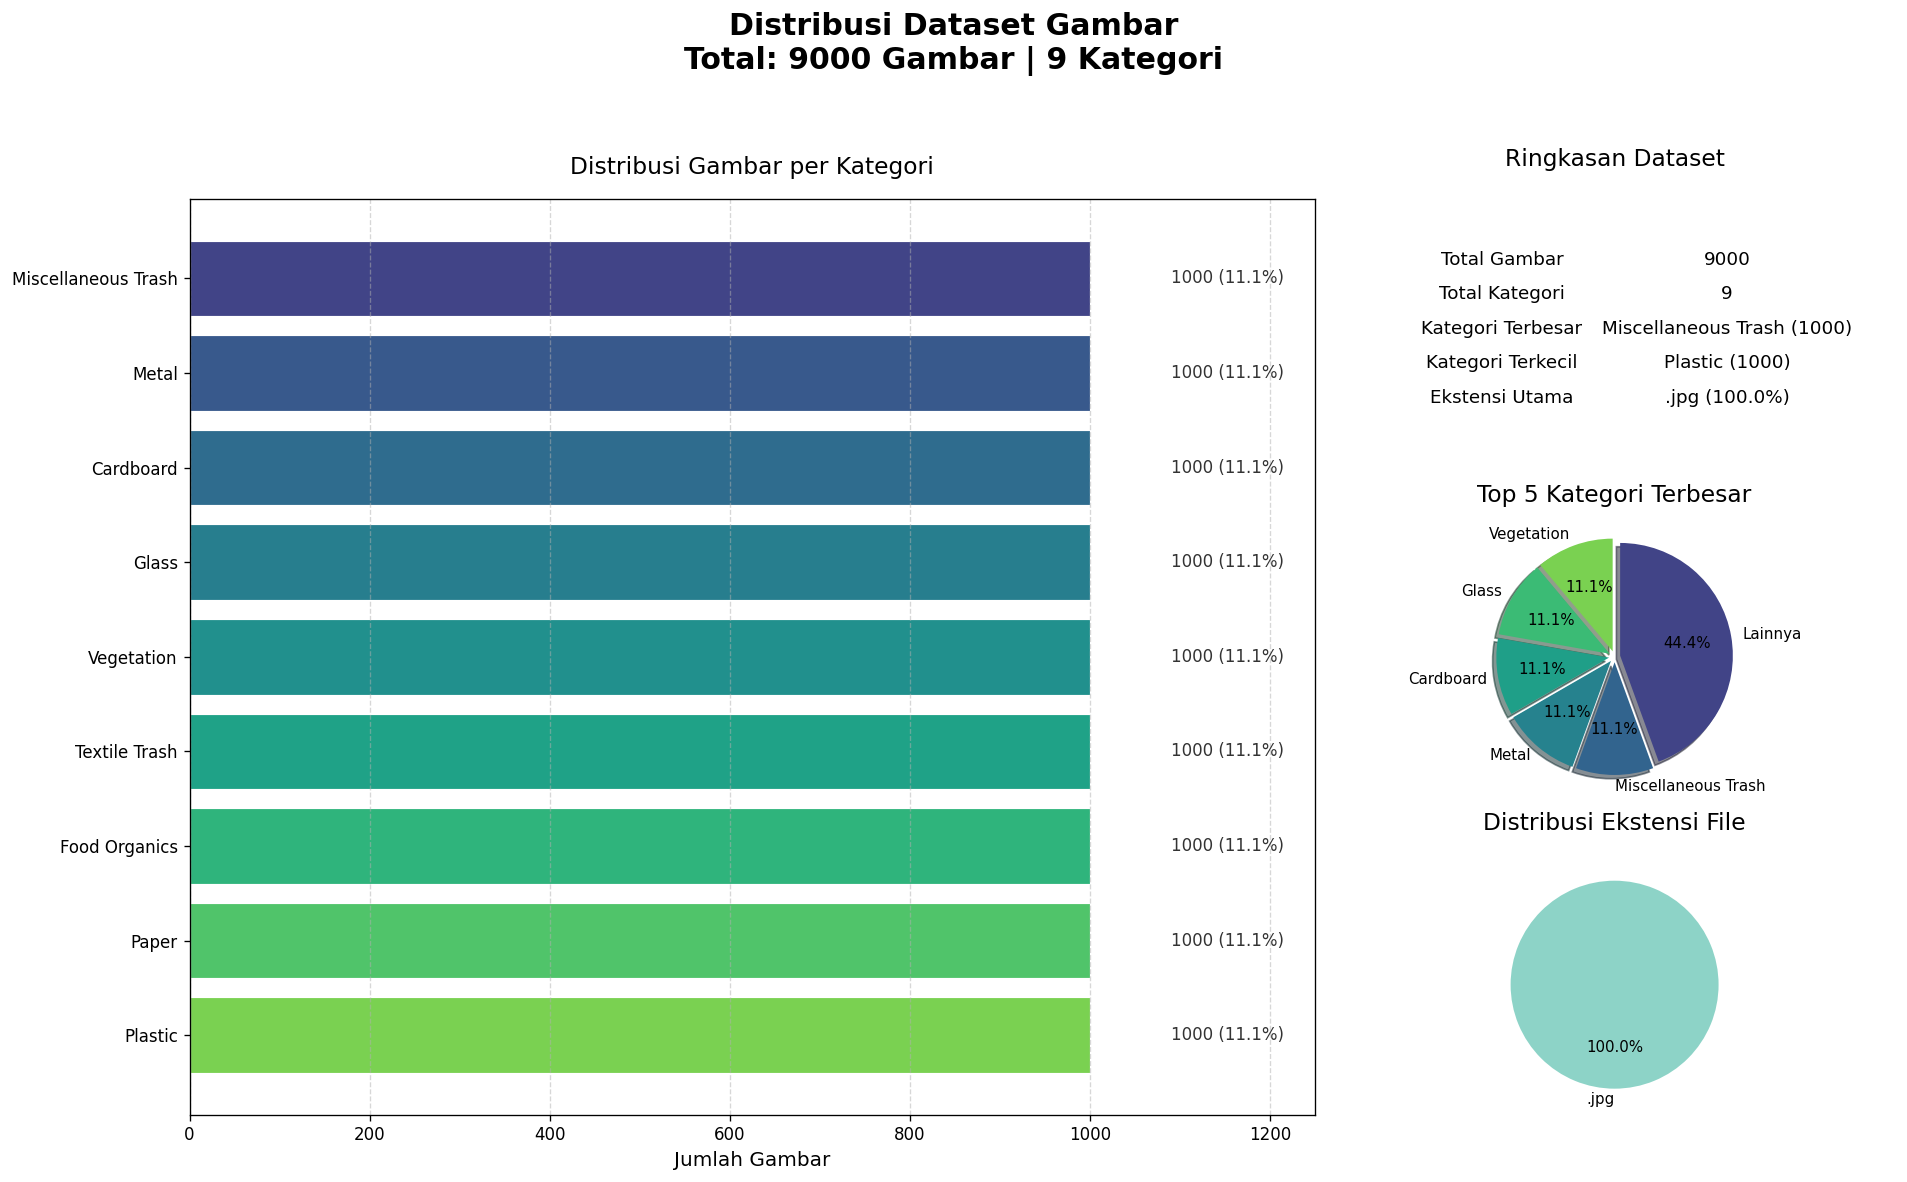

In [13]:
dataset_df = analyze_dataset_distribution(
    dataset_path="/kaggle/working/RealWaste"
)

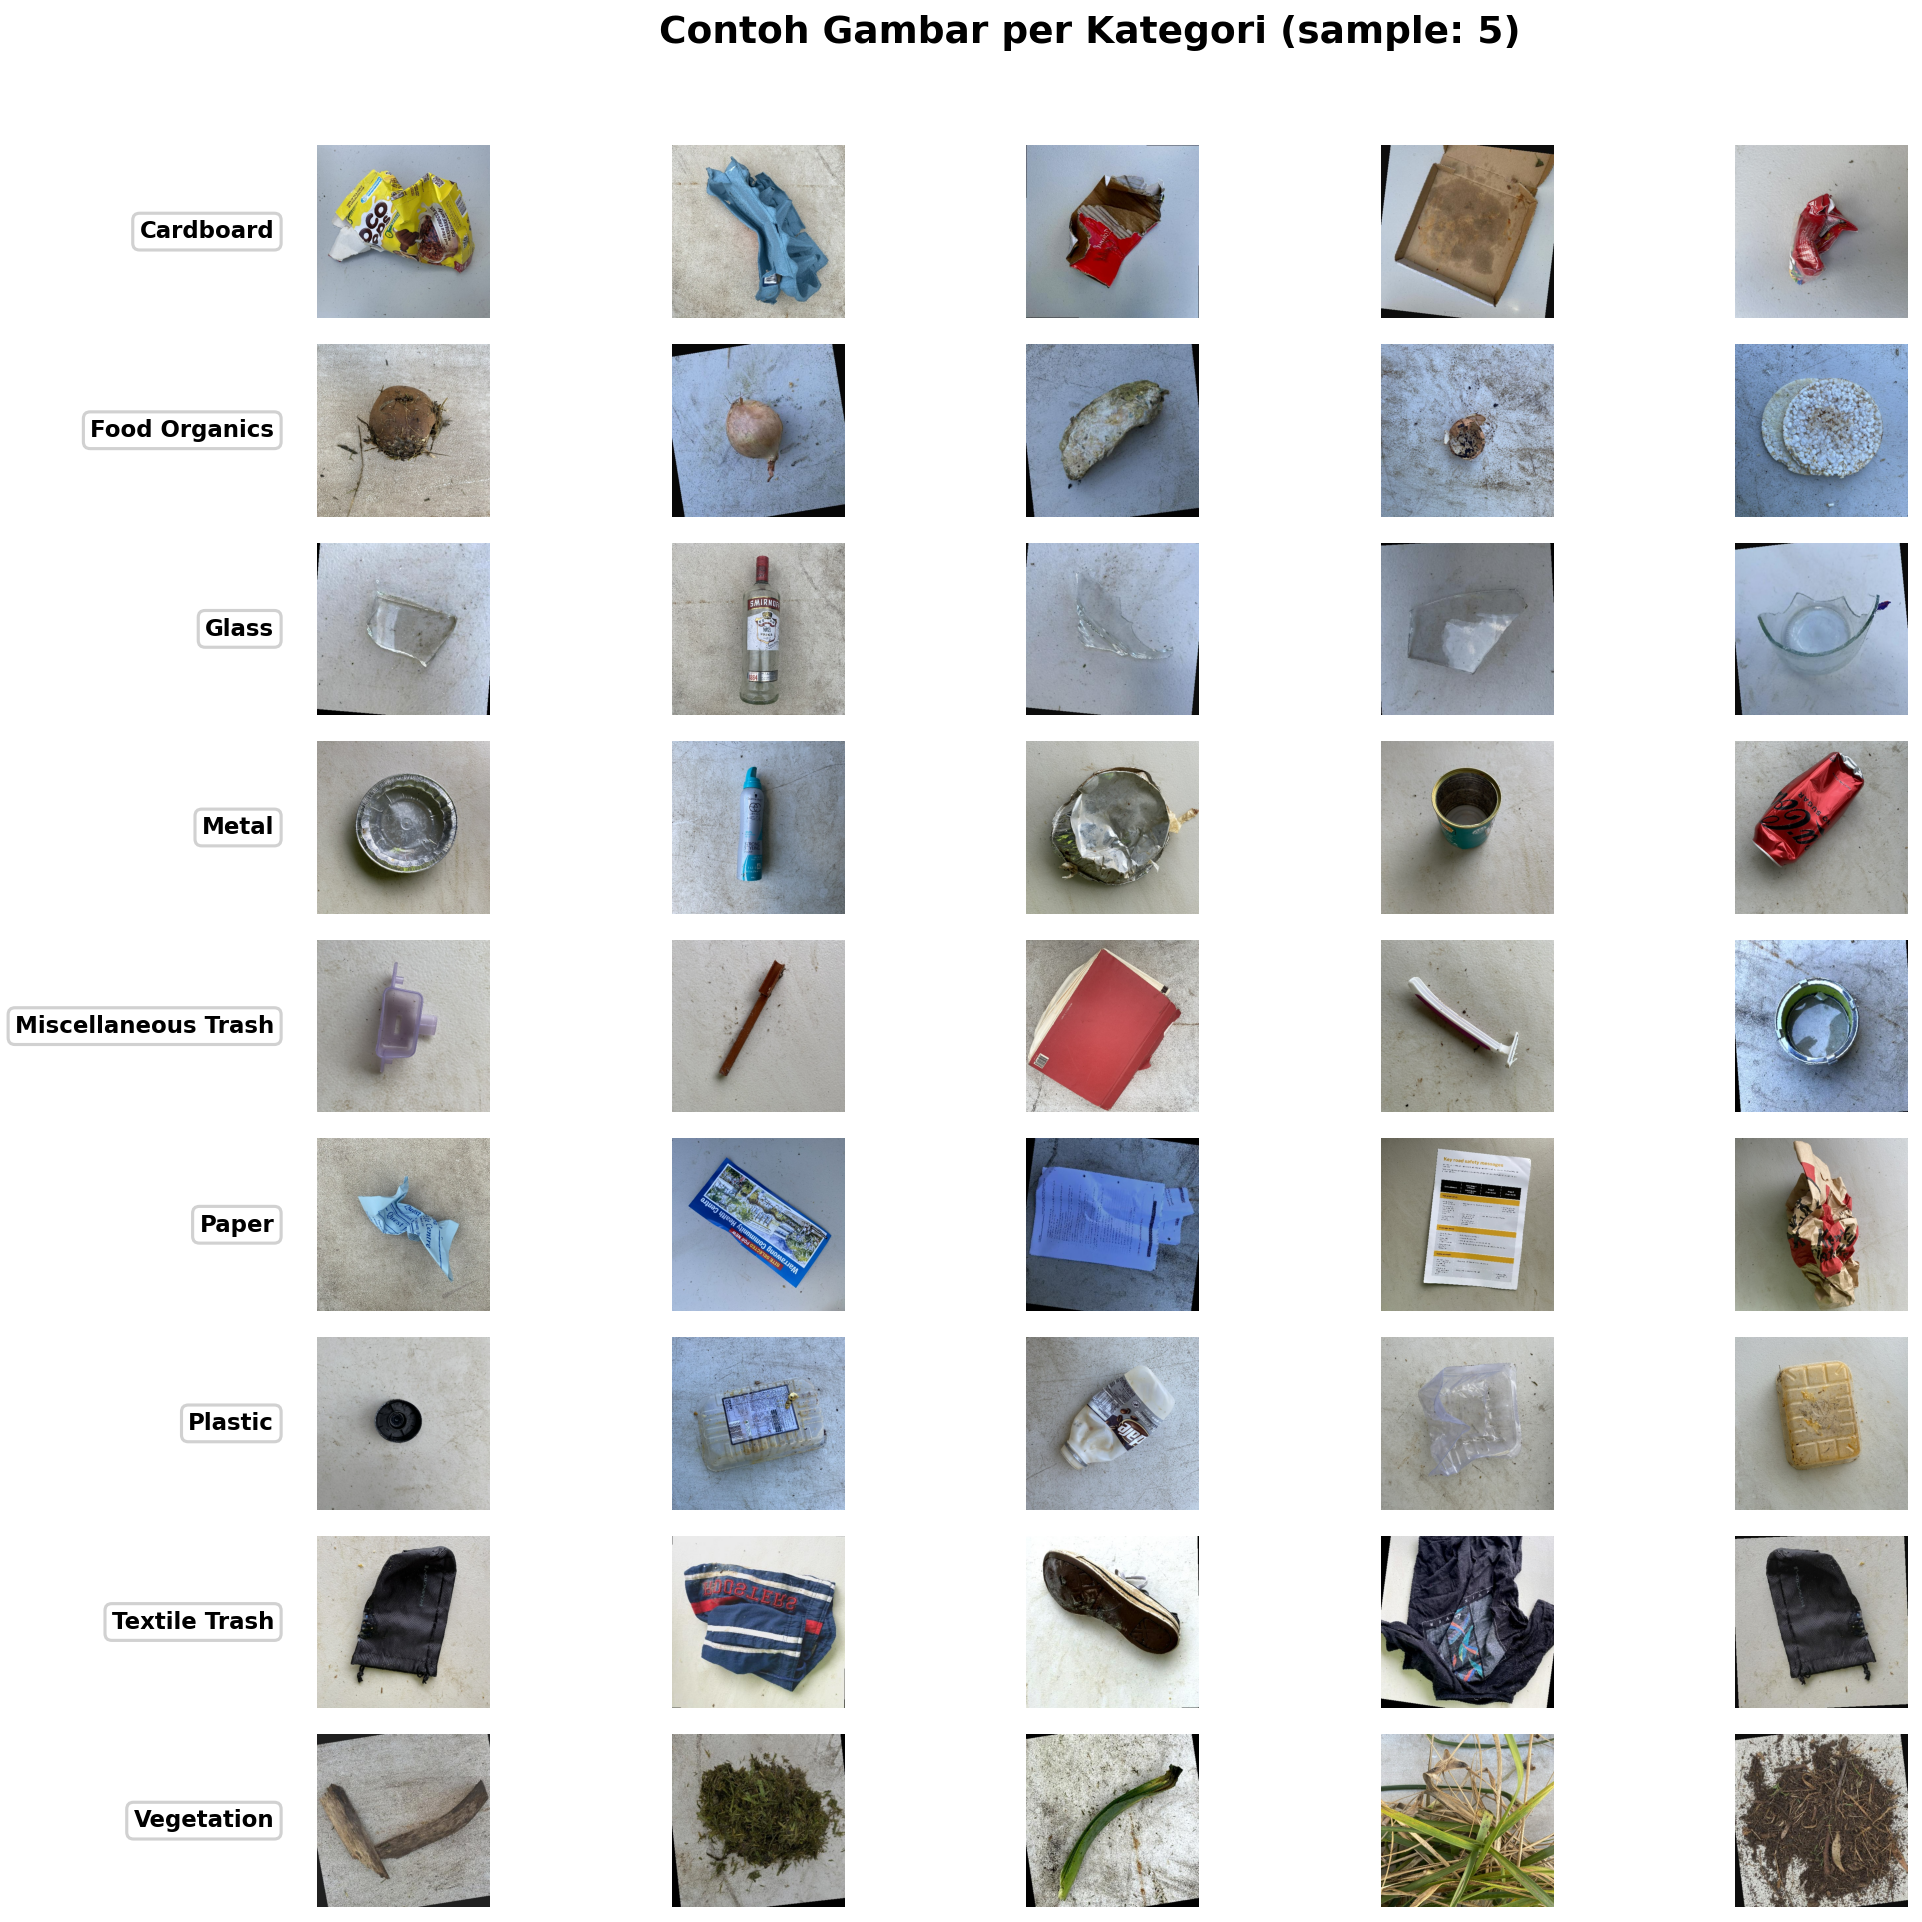

In [14]:
fig = plot_category_samples(
    dataset_path="/kaggle/working/RealWaste",
    samples_per_category=5,
    figsize=(15, 10),
    label_fontsize=11,
    title_fontsize=18,
    dpi=150
)
fig.savefig("preview_aug.png")  # Untuk menyimpan hasil
plt.show()

## Data Splitting

In [15]:
def split_dataset(
    source_dir: str,
    dest_dir: str,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Rasio harus total 100%"

    random.seed(seed)

    # Buat folder target jika belum ada
    for split in ['train', 'val', 'test']:
        for class_name in os.listdir(source_dir):
            class_path = os.path.join(source_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            target_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(target_dir, exist_ok=True)

    # Split data
    for class_name in tqdm(os.listdir(source_dir), desc="📂 Splitting dataset"):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_imgs in splits.items():
            for img in split_imgs:
                src_img_path = os.path.join(class_path, img)
                dst_img_path = os.path.join(dest_dir, split, class_name, img)
                shutil.copyfile(src_img_path, dst_img_path)

    print("✅ Splitting selesai.")

In [16]:
split_dataset(
    source_dir='/kaggle/working/RealWaste',
    dest_dir='/kaggle/working/split_dataset',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

📂 Splitting dataset: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]

✅ Splitting selesai.


## Pemodelan

In [17]:
# Load YOLOv8 classification model
model = YOLO('yolov8s-cls.pt')  # small model (lebih akurat dari 'n')

100%|██████████| 12.3M/12.3M [00:00<00:00, 117MB/s]


In [18]:
model.train(
    data='/kaggle/working/split_dataset',  # berisi subfolder 'train' dan 'val'
    epochs=50,
    imgsz=640,         # ukuran lebih besar = lebih akurat
    batch=16,          # tetap aman di Kaggle (jika crash, turunkan ke 8)
    patience=10,
    lr0=0.001,
    weight_decay=0.0005,
    optimizer='Adam',
    device=0,          # pakai GPU Kaggle
    augment=False,     # matikan augmentasi online
    verbose=True,
    workers=2          # cegah overload thread Kaggle
)

Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/split_dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrain

100%|██████████| 5.35M/5.35M [00:00<00:00, 73.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2356.9±1259.6 MB/s, size: 110.3 KB)


train: Scanning /kaggle/working/split_dataset/train... 6300 images, 0 corrupt: 100%|██████████| 6300/6300 [00:02<00:00, 3024.49it/s]

train: New cache created: /kaggle/working/split_dataset/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1069.4±624.0 MB/s, size: 94.1 KB)


val: Scanning /kaggle/working/split_dataset/val... 1350 images, 0 corrupt: 100%|██████████| 1350/1350 [00:00<00:00, 3091.73it/s]

val: New cache created: /kaggle/working/split_dataset/val.cache


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      2.37G      2.182         16        640:   1%|          | 3/394 [00:03<05:22,  1.21it/s]

       1/50      2.37G      2.202         16        640:   2%|▏         | 6/394 [00:03<02:02,  3.18it/s]
100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:15<00:00,  2.70it/s]

                   all      0.741      0.985



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:15<00:00,  2.72it/s]

                   all      0.823      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.09it/s]

                   all      0.841      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.21it/s]

                   all      0.861      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]

                   all      0.859      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]

                   all      0.907      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.01it/s]

                   all      0.924      0.999



      Epoch    GPU_mem       loss  Instances       Size


      10/50      3.16G     0.3073         12        640: 100%|██████████| 394/394 [02:02<00:00,  3.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.19it/s]

                   all       0.91      0.999



      Epoch    GPU_mem       loss  Instances       Size


      11/50      3.17G     0.2859         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.09it/s]

                   all      0.911      0.999



      Epoch    GPU_mem       loss  Instances       Size


      12/50      3.19G     0.2521         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50       3.2G     0.2422         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.06it/s]

                   all       0.93      0.999



      Epoch    GPU_mem       loss  Instances       Size


      14/50      3.21G     0.2512         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]

                   all      0.936      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/50      3.22G     0.2253         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]


                   all      0.938      0.999

      Epoch    GPU_mem       loss  Instances       Size


      16/50      3.23G     0.2031         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.02it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      3.24G       0.17         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      3.26G     0.1583         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.10it/s]

                   all      0.949      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/50      3.27G     0.1742         12        640: 100%|██████████| 394/394 [02:02<00:00,  3.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.02it/s]

                   all      0.939      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/50      3.28G     0.1777         12        640: 100%|██████████| 394/394 [02:02<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      3.29G     0.1762         12        640: 100%|██████████| 394/394 [02:02<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]

                   all       0.96      0.999



      Epoch    GPU_mem       loss  Instances       Size


      22/50       3.3G     0.1538         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]

                   all       0.95      0.999



      Epoch    GPU_mem       loss  Instances       Size


      23/50      3.31G     0.1413         12        640: 100%|██████████| 394/394 [02:02<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.26it/s]

                   all      0.954      0.999



      Epoch    GPU_mem       loss  Instances       Size


      24/50      3.33G     0.1358         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.12it/s]

                   all      0.959      0.999



      Epoch    GPU_mem       loss  Instances       Size


      25/50      3.34G     0.1294         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      3.35G     0.1207         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      27/50      3.36G     0.1013         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.07it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      3.37G    0.08992         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  2.99it/s]

                   all       0.96      0.999



      Epoch    GPU_mem       loss  Instances       Size


      29/50      3.38G    0.08084         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.06it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      30/50      3.39G     0.0973         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.10it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      3.41G    0.07957         12        640: 100%|██████████| 394/394 [02:06<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.03it/s]

                   all      0.959      0.999



      Epoch    GPU_mem       loss  Instances       Size


      32/50      3.42G    0.08727         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.08it/s]

                   all      0.966      0.999



      Epoch    GPU_mem       loss  Instances       Size


      33/50      3.43G    0.07988         12        640: 100%|██████████| 394/394 [02:07<00:00,  3.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.08it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      3.44G    0.07079         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]

                   all      0.968      0.999



      Epoch    GPU_mem       loss  Instances       Size


      35/50      3.45G    0.06666         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.11it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      3.46G    0.06013         12        640: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.07it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      3.48G    0.05853         12        640: 100%|██████████| 394/394 [02:06<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.04it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      3.49G    0.06002         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]

                   all      0.973      0.999



      Epoch    GPU_mem       loss  Instances       Size


      39/50       3.5G    0.04303         12        640: 100%|██████████| 394/394 [02:06<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  2.97it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


      40/50      3.51G    0.03668         12        640: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.00it/s]

                   all      0.976      0.999



      Epoch    GPU_mem       loss  Instances       Size


      41/50      3.52G    0.03783         12        640: 100%|██████████| 394/394 [02:07<00:00,  3.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


      42/50      3.54G    0.03901         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      3.55G    0.03226         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.06it/s]

                   all      0.976      0.999



      Epoch    GPU_mem       loss  Instances       Size


      44/50      3.56G    0.03257         12        640: 100%|██████████| 394/394 [02:07<00:00,  3.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.07it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      3.57G    0.02856         12        640: 100%|██████████| 394/394 [02:08<00:00,  3.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.11it/s]

                   all      0.981      0.999



      Epoch    GPU_mem       loss  Instances       Size


      46/50      4.07G    0.02935         12        640: 100%|██████████| 394/394 [02:09<00:00,  3.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s]

                   all      0.979      0.999



      Epoch    GPU_mem       loss  Instances       Size


      47/50      4.08G    0.02557         12        640: 100%|██████████| 394/394 [02:05<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]

                   all      0.978      0.999



      Epoch    GPU_mem       loss  Instances       Size


      48/50       4.1G    0.02522         12        640: 100%|██████████| 394/394 [02:09<00:00,  3.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  3.01it/s]

                   all      0.976      0.999



      Epoch    GPU_mem       loss  Instances       Size


      49/50      4.11G    0.02462         12        640: 100%|██████████| 394/394 [02:07<00:00,  3.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.27it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      4.12G    0.02054         12        640: 100%|██████████| 394/394 [02:06<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:13<00:00,  3.11it/s]

                   all      0.979      0.999



50 epochs completed in 1.929 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train/weights/best.pt, 10.3MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,086,729 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/working/split_dataset/train... found 6300 images in 9 classes ✅ 
val: /kaggle/working/split_dataset/val... found 1350 images in 9 classes ✅ 
test: /kaggle/working/split_dataset/test... found 1350 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:14<00:00,  2.98it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.981      0.999
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc3d54e4f10>
curves: []
curves_results: []
fitness: 0.9899999797344208
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9807407259941101, 'metrics/accuracy_top5': 0.9992592334747314, 'fitness': 0.9899999797344208}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.4708803022232907, 'inference': 2.243815822221896, 'loss': 0.0004858666667402118, 'postprocess': 0.00104780740878562}
task: 'classify'
top1: 0.9807407259941101
top5: 0.9992592334747314

## Evaluasi

In [19]:
# Load model terbaik
model = YOLO('runs/classify/train/weights/best.pt')

# Evaluasi dengan data test
metrics = model.val(
    data='/kaggle/working/split_dataset/test',
    imgsz=640
)

# Tampilkan metrik utama dari hasil evaluasi
print("📊 Accuracy Top-1:", metrics.top1)
print("📊 Accuracy Top-5:", metrics.top5)

Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,086,729 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=train' not found at /kaggle/working/split_dataset/test/train
Found 1350 images in subdirectories. Attempting to split...
Splitting /kaggle/working/split_dataset/test (9 classes, 1350 images) into 80% train, 20% val...
Split complete in /kaggle/working/split_dataset/test_split ✅
train: /kaggle/working/split_dataset/test_split/train... found 1080 images in 9 classes ✅ 
val: /kaggle/working/split_dataset/test_split/val... found 270 images in 9 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1493.8±791.7 MB/s, size: 88.5 KB)


val: Scanning /kaggle/working/split_dataset/test_split/val... 270 images, 0 corrupt: 100%|██████████| 270/270 [00:00<00:00, 2984.08it/s]

val: New cache created: /kaggle/working/split_dataset/test_split/val.cache



               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.985          1
Speed: 2.9ms preprocess, 6.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val
📊 Accuracy Top-1: 0.9851852059364319
📊 Accuracy Top-5: 1.0


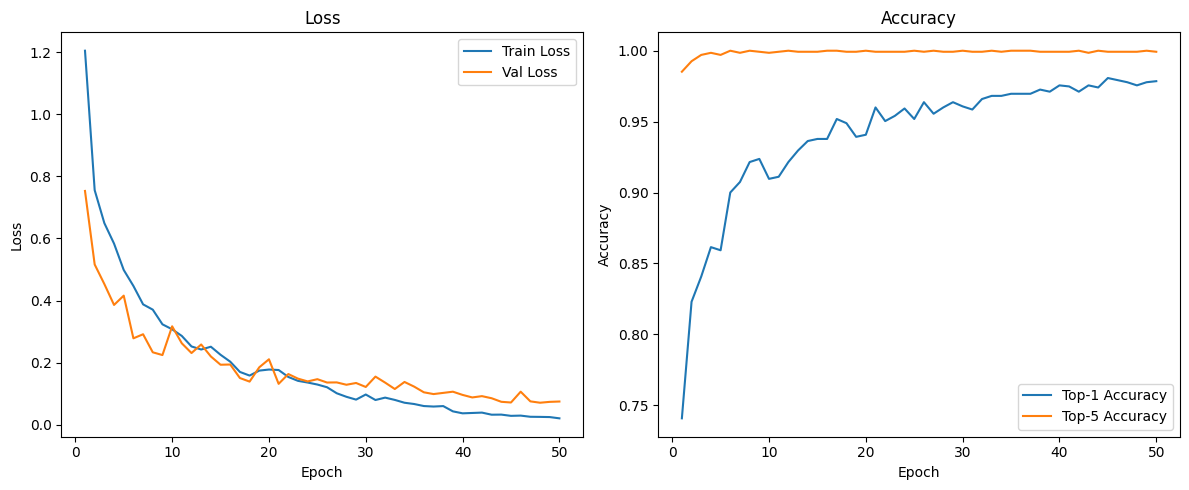

In [20]:
# Load hasil training
df = pd.read_csv('runs/classify/train/results.csv')

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/loss'], label='Train Loss')
plt.plot(df['epoch'], df['val/loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy')
plt.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Save Model

In [21]:
# Path ke model terbaik yang sudah dihasilkan YOLOv8
src_path = 'runs/classify/train/weights/best.pt'

# Buat direktori tujuan jika belum ada
os.makedirs('saved_models', exist_ok=True)

# Salin dan beri nama baru
dst_path = 'saved_models/best_classification_model.pt'
shutil.copy(src_path, dst_path)

print(f"✅ Model berhasil disimpan di: {dst_path}")

✅ Model berhasil disimpan di: saved_models/best_classification_model.pt


In [22]:
# Load ulang model terbaik
model = YOLO(src_path)

# Export ke ONNX
model.export(format='onnx', imgsz=640)       # hasil: best.onnx

# Export ke TorchScript
model.export(format='torchscript', imgsz=640) # hasil: best.torchscript.pt

# Export ke TensorFlow Lite
model.export(format='tflite', imgsz=640)      # hasil: best.tflite

# Export ke TensorFlow.js
model.export(format='tfjs', imgsz=640)        # hasil: best_web_model(s)

Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8s-cls summary (fused): 30 layers, 5,086,729 parameters, 0 gradients, 12.5 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9) (9.8 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 5.2s, saved as 'runs/classify/train/weights/best.onnx' (19.4 MB)

Export complete (5.8s)
Results saved to /kaggle/working/runs/classify/train/weights
Predict:         yolo predict task=classify model=ru

E0000 00:00:1749109947.583061      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749109947.658321      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx2tf>=1.26.3', 'protobuf>=5'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.18.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 24.4MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 51.18file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 0.8s, saved as 'runs/classify/train/weights/best.onnx' (19.4 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.27.10...


I0000 00:00:1749109963.753271      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Saved artifact at 'runs/classify/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 9), dtype=tf.float32, name=None)
Captures:
  140482667015696: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140482667014160: TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name=None)
  140482667016080: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  140482667019344: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  140482667018960: TensorSpec(shape=(3, 3, 32, 64), dtype=tf.float32, name=None)
  140482667019920: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  140482667017808: TensorSpec(shape=(1, 1, 64, 64), dtype=tf.float32, name=None)
  140482667020112: TensorSpec(shape=(64,), dtype=tf.float32, name=None)
  140482360885712: TensorSpec(shape=(4,), dtype=tf.int64, name=None)
  140482360885520: 

I0000 00:00:1749109970.397222      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749109970.397392      19 single_machine.cc:361] Starting new session
I0000 00:00:1749109970.398966      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
W0000 00:00:1749109971.535872      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749109971.535908      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749109972.519946      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749109972.520103      19 single_machine.cc:361] Starting new session
I0000 00:00:1749109972.521367      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesl

TensorFlow SavedModel: export success ✅ 29.2s, saved as 'runs/classify/train/weights/best_saved_model' (48.7 MB)

TensorFlow Lite: starting export with tensorflow 2.18.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/classify/train/weights/best_saved_model/best_float32.tflite' (19.4 MB)

Export complete (29.6s)
Results saved to /kaggle/working/runs/classify/train/weights
Predict:         yolo predict task=classify model=runs/classify/train/weights/best_saved_model/best_float32.tflite imgsz=640  
Validate:        yolo val task=classify model=runs/classify/train/weights/best_saved_model/best_float32.tflite imgsz=640 data=/kaggle/working/split_dataset  
Visualize:       https://netron.app
Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv8s-cls summary (fused): 30 layers, 5,086,729 parameters, 0 gradients, 12.5 GFLOPs

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9)

I0000 00:00:1749109980.960595      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749109980.960769      19 single_machine.cc:361] Starting new session
I0000 00:00:1749109980.962056      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
W0000 00:00:1749109982.037621      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749109982.037653      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749109982.876209      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749109982.876372      19 single_machine.cc:361] Starting new session
I0000 00:00:1749109982.877698      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesl

TensorFlow SavedModel: export success ✅ 9.9s, saved as 'runs/classify/train/weights/best_saved_model' (48.7 MB)

TensorFlow GraphDef: starting export with tensorflow 2.18.0...


I0000 00:00:1749109985.227742      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749109985.227902      19 single_machine.cc:361] Starting new session
I0000 00:00:1749109985.229283      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12586 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


TensorFlow GraphDef: export success ✅ 1.6s, saved as 'runs/classify/train/weights/best.pb' (19.5 MB)
requirements: Ultralytics requirement ['tensorflowjs'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect




TensorFlow.js: starting export with tensorflowjs 4.22.0...

TensorFlow.js: output node names: Identity:0
TensorFlow.js: running 'tensorflowjs_converter --input_format=tf_frozen_model  --output_node_names=Identity:0 "runs/classify/train/weights/best.pb" "runs/classify/train/weights/best_web_model"'


E0000 00:00:1749109988.401480     334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749109988.407857     334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


weight model_1/tf.strided_slice_14/ones_like/tensor with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_14/StridedSlice/end with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_14/ones_like with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_12/ones_like/tensor with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_12/StridedSlice/end with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_12/ones_like with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_10/ones_like/tensor with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_10/StridedSlice/end with shape (4,) and dtype int64 was auto converted to the type int32
weight model_1/tf.strided_slice_10/ones_like w

'runs/classify/train/weights/best_web_model'

## Inference

In [23]:
def classify_image_from_url(model_path: str, img_url: str):
    # Load model terbaik
    model = YOLO(model_path)
    
    # Ambil gambar dari URL
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    
    # Daftar nama kelas
    class_names = [
        "Cardboard",
        "Food Organics",
        "Glass",
        "Metal",
        "Miscellaneous Trash",
        "Paper",
        "Plastic",
        "Textile Trash",
        "Vegetation"
    ]
    
    # Jalankan inference
    results = model(img, imgsz=640)
    
    # Ambil prediksi dan confidence tertinggi
    predicted_label = results[0].probs.top1
    confidence = results[0].probs.top1conf.item()
    
    # Ambil confidence untuk semua kelas (probs adalah tensor PyTorch)
    probs_all = results[0].probs.data.tolist()  # List float per kelas
    
    # Urutkan index kelas berdasarkan confidence tertinggi
    top5_indices = sorted(range(len(probs_all)), key=lambda i: probs_all[i], reverse=True)[:5]
    
    # Buat string top 5 kelas dan persen confidence-nya
    top5_conf_str = ", ".join(
        [f"{class_names[i]} {probs_all[i]*100:.2f}%" for i in top5_indices]
    )
    
    # Print hasil lengkap
    print(f"Prediksi kelas: {class_names[predicted_label]}, Confidence: {confidence:.4f}")
    print(f"Top 5 confidence per kelas: {top5_conf_str}")
    
    # Tampilkan gambar dengan title hasil prediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[predicted_label]} ({confidence:.2%})")
    plt.axis('off')
    plt.show()



0: 640x640 Vegetation 0.78, Paper 0.07, Plastic 0.07, Cardboard 0.05, Metal 0.04, 7.8ms
Speed: 32.3ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Prediksi kelas: Vegetation, Confidence: 0.7811
Top 5 confidence per kelas: Vegetation 78.11%, Paper 6.62%, Plastic 6.58%, Cardboard 4.91%, Metal 3.76%


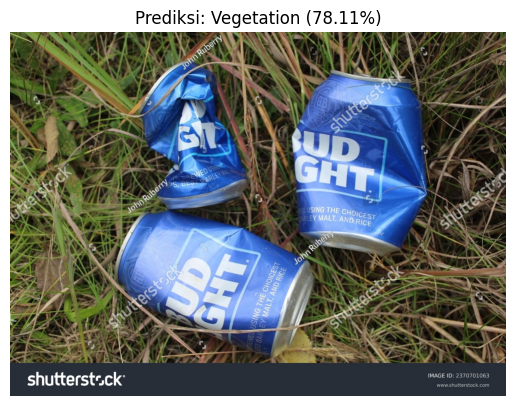

In [24]:
classify_image_from_url(
    model_path='saved_models/best_classification_model.pt', 
    img_url='https://www.shutterstock.com/shutterstock/photos/2370701063/display_1500/stock-photo-park-ridge-illinois-usa-october-three-dented-bud-light-beer-cans-in-grass-2370701063.jpg')